# Косенко Никита
## Лабораторная работа №2, вариант 9

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

Подключаем данные

In [236]:
data = pd.read_csv('data_ml_v2-09.csv')
X = data[['x1', 'x2']]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)
data

,x1,x2,label
0,2.09900,1.18550,1
1,4.08970,2.34480,1
2,2.29870,1.53440,1
3,2.31340,0.83835,1
4,2.77860,0.52184,1
...,...,...,...
495,0.74488,4.03800,4
496,0.97697,3.33700,4
497,-0.38525,5.38230,4
498,1.28370,2.65840,4


### Задание 1
Оценить ковариационные матрицы обучающих данных для каждого класса при различных предположениях:

a) ковариационные матрицы всех классов равные, скалярные

б) равные, диагональные

в) различные, скалярные

г) различные, диагональные

д) равные

е) различные

Визуализировать матрицы для каждого случая.

In [237]:
# Получаем уникальные классы
classes = y_train.unique()

# Инициализируем словарь для хранения ковариационных матриц
cov_matrices = {}

In [238]:
# a) ковариационные матрицы всех классов равные, скалярные
cov_equal_scalar = np.cov(X_train.T) * np.eye(X_train.shape[1])
cov_matrices['equal, scalar'] = cov_equal_scalar

In [239]:
# б) равные, диагональные
cov_equal_diagonal = np.diag(np.var(X_train, axis=0))
cov_matrices['equal, diagonal'] = cov_equal_diagonal

In [240]:
# в) различные, скалярные
for cls in classes:
    cov_matrices[f'different, scalar, class {cls}'] = np.cov(X_train[y_train == cls].T) * np.eye(X_train.shape[1])

In [241]:
# г) различные, диагональные
for cls in classes:
    cov_matrices[f'different, diagonal, class {cls}'] = np.diag(np.var(X_train[y_train == cls], axis=0))

In [242]:
# д) равные
cov_equal = np.cov(X_train.T)
cov_matrices['equal'] = cov_equal

In [243]:
# е) различные
for cls in classes:
    cov_matrices[f'different, class {cls}'] = np.cov(X_train[y_train == cls].T)

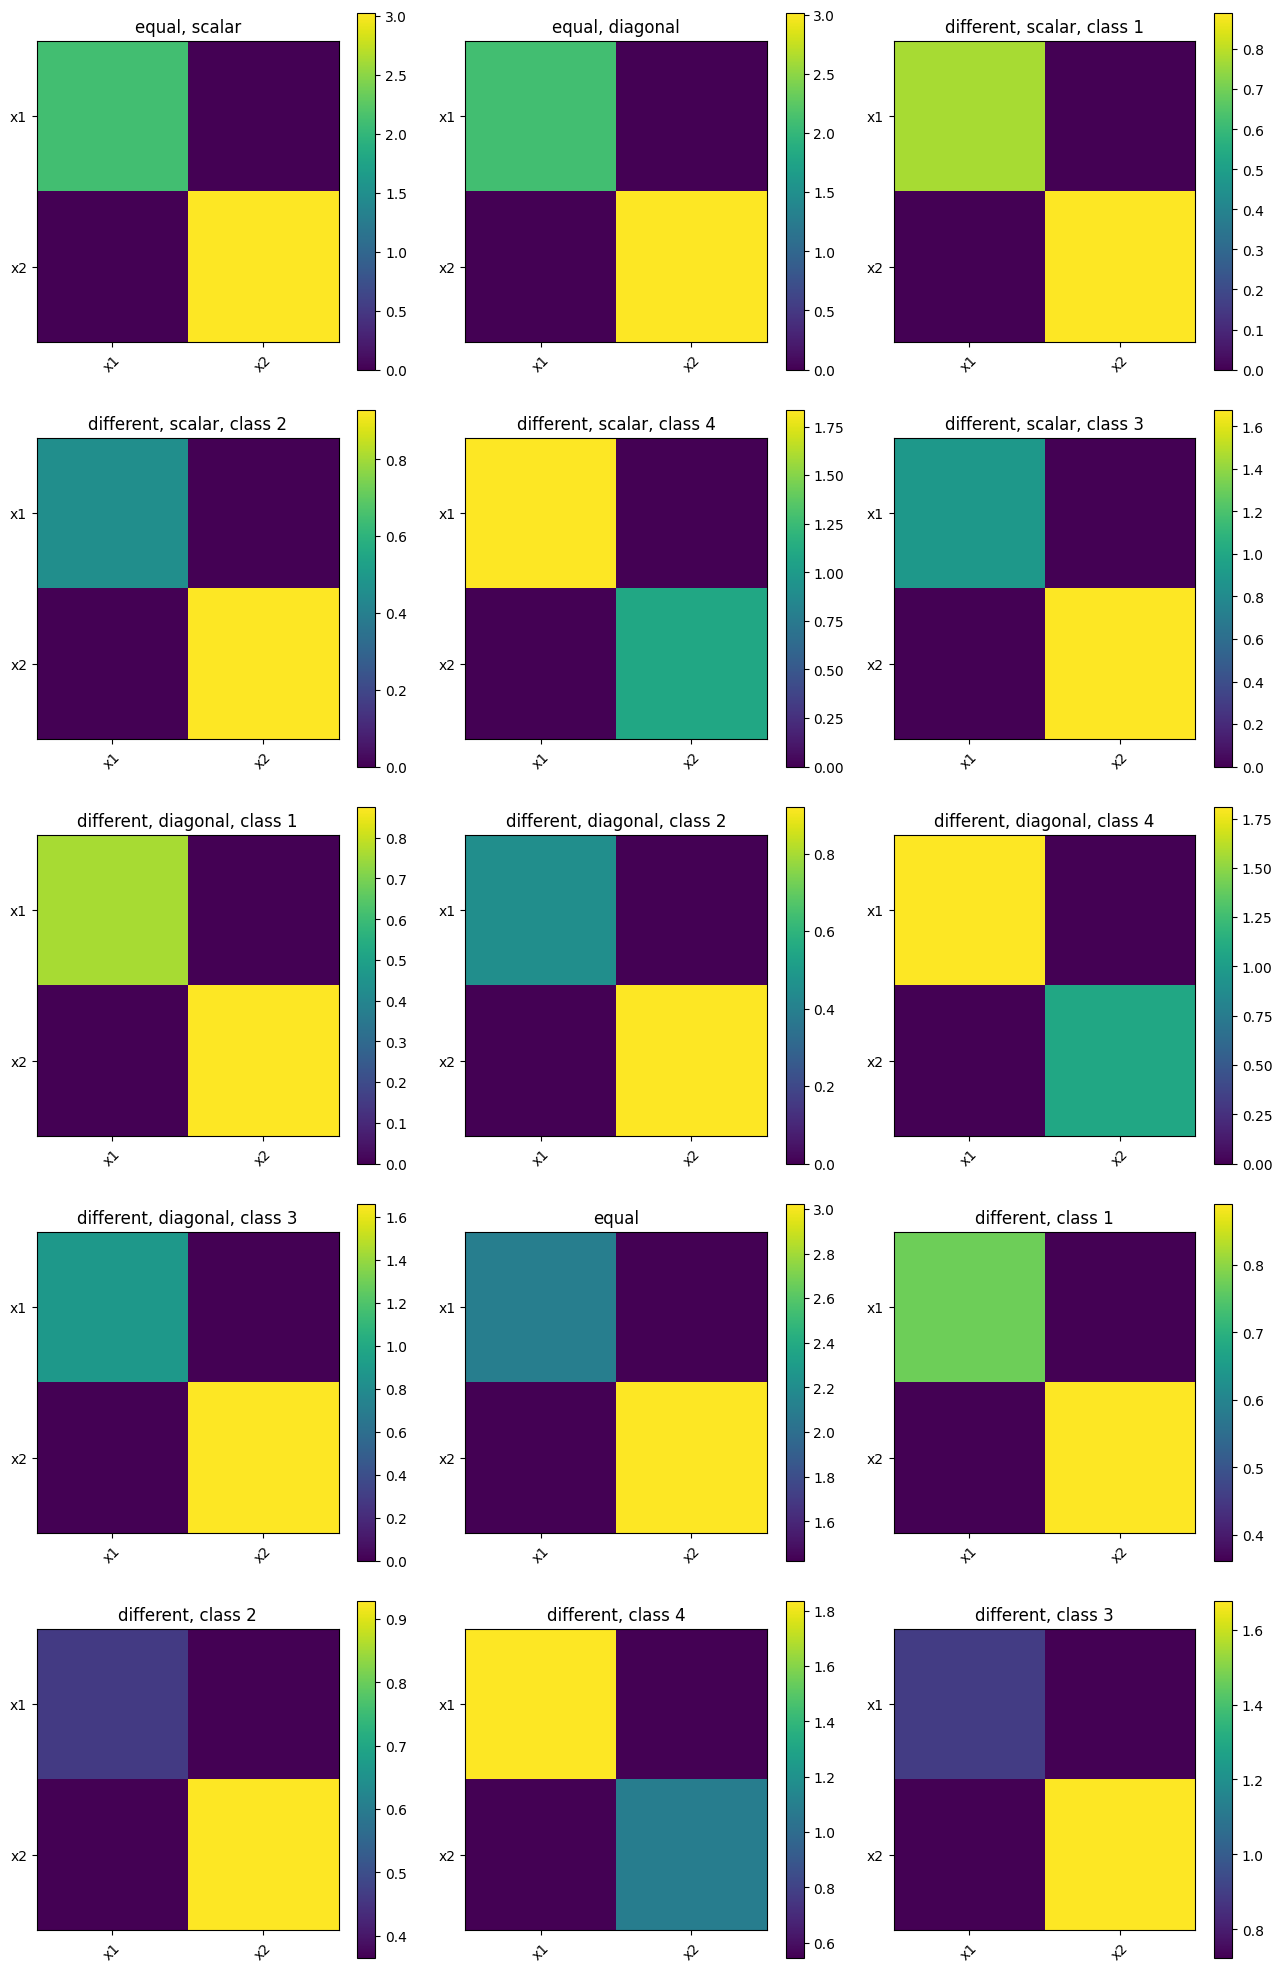

In [244]:

# Визуализация ковариационных матриц
num_matrices = len(cov_matrices)
rows = (num_matrices // 3) + (num_matrices % 3 > 0)  # Определяем количество строк
plt.figure(figsize=(13, 4 * rows))
for i, (key, cov_matrix) in enumerate(cov_matrices.items()):
    plt.subplot(rows, 3, i + 1)
    plt.imshow(cov_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(key)
    plt.xticks(range(cov_matrix.shape[0]), ['x1', 'x2'], rotation=45)
    plt.yticks(range(cov_matrix.shape[0]), ['x1', 'x2'])

plt.tight_layout()
plt.show()

### Задание 2
Рассчитать классификационные очки обученных байесовских классификаторов (при предположениях а-е) пункта 1 для примеров обучающей и тестовой выборок

### Задание 3
В исходном пространстве признаков изобразить области классов (закрасить разными цветами), формируемые каждым из обученных классификаторов. Нанести на диаграммы границы классов и данные из обучающей и тестовой выборок. На отдельной диаграмме изобразить все границы классов, формируемые построенными классификаторами.

### Задание 4
Рассчитать точности (accuracy) построенных классификаторов на обучающей и тестовой выборках, представить данные в графическом виде (bar charts).

### Задание 5
Для каждого классификатора построить micro-averaged и macro-averaged ROC-кривые и PR-кривые на обучающей и тестовой выборках и рассчитать micro-averaged и macro-averaged ROC AUC и PR AUC на обучающей и тестовой выборках.

### Задание 6
Сделать выводы о влиянии предположений о модели обучающих данных на точность байесовской классификации.